In [1]:
# 이전 참고: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html(실패)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import shutil

filename = 'open-korean-text-2.1.0.jar'
src = '/content/drive/MyDrive/data/'
dir = '/usr/local/lib/python3.10/dist-packages/konlpy/java/'
shutil.copy(src + filename, dir + filename)

'/usr/local/lib/python3.10/dist-packages/konlpy/java/open-korean-text-2.1.0.jar'

# Requirement load

In [4]:
import numpy as np
import pandas as pd
import os
import re
import random
import shutil

from tqdm import tqdm

# Data preprocessing
from konlpy.tag import Okt
from gensim.models import FastText # https://wikidocs.net/22883

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
path = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_2/'

In [6]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))

# Okt 사용자 정의 사전 등록

In [7]:
# 임시 폴더에 Okt 사전 파일 압축 풀기
os.chdir('/usr/local/lib/python3.10/dist-packages/konlpy/java')
os.getcwd()

!pwd

/usr/local/lib/python3.10/dist-packages/konlpy/java


In [8]:
filename = 'open-korean-text-2.1.0.jar'
src = '/content/drive/MyDrive/data/'
dir = '/usr/local/lib/python3.10/dist-packages/konlpy/java/'
shutil.copy(src + filename, dir + filename)

'/usr/local/lib/python3.10/dist-packages/konlpy/java/open-korean-text-2.1.0.jar'

## csv 파일에 정의한 예외 처리 단어 목록 불러오기

In [9]:
vocab = pd.read_csv(os.path.join(path, 'vocab.csv'))

# Data preprocess

In [10]:
okt = Okt()

In [13]:
def tokenize(text):
  result = list()
  # 사용자 정의 지정 표현 수동으로 변환시켜주기
  for key, replace in zip(vocab['key'].values, vocab['replace'].values):
    try:
      text = re.sub(key, replace, text)
    except:
      continue
  # ') 깨문', '병@(#%^신' 처리
  text =re.sub(r'\) 깨문', '대깨문', text)
  text =re.sub(r'병[@#%^]?\(*\)?.*?신', "병신", text)
  text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]"," ", text) # 한글 아니면 전부 삭제
  text = re.sub('[ㄱ-ㅎ]+', '', text) # 자음으로만 이루어진 경우 삭제
  text = re.sub('[ㅏ-ㅣ]+', '', text) # 모음으로만 이루어진 경우 삭제
  # tokenize
  text = okt.pos(text, norm=True, stem=True)
  for txt, tag in text:
    result.append(txt)
  return result

In [14]:
clean_train_text = [ tokenize(text) for text in train_df['text']]
clean_test_text = [ tokenize(text) for text in test_df['text']]
clean_full_text = clean_train_text + clean_test_text

In [15]:
clean_train_label = train_df['label']

clean_train_text[:5]

[['유소영', '비호감', '성형', '아줌마'],
 ['나오다', '썅'],
 ['식상하다', '지긋지긋하다', '자다', '끝나다', '오예', '소리', '벗다', '빤스', '지르다'],
 ['성희롱', '당하다', '얼굴', '이', '아니다'],
 ['끝', '까지', '해보다', '쪽바리', '원숭이', '자유', '한국', '당', '쓰레기']]

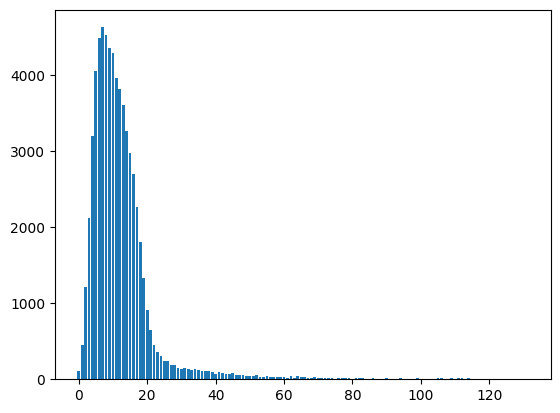

In [16]:
from collections import Counter

clean_train_text_len = [ len(text) for text in clean_train_text ]
len_counter = Counter(clean_train_text_len)
plt.bar(len_counter.keys(), len_counter.values())
plt.show()

# Embedding

In [17]:
import logging
fast_text_model = FastText(vector_size=120, window=3, min_count=1, sentences=clean_full_text, epochs=20)

In [19]:
fast_text_model.wv.most_similar("문재인")

[('문재잉', 0.9467929005622864),
 ('황동주', 0.8938043713569641),
 ('뮨재인', 0.8861815333366394),
 ('빼버리긔', 0.8825953602790833),
 ('문재앙', 0.8272093534469604),
 ('김재인', 0.8190740346908569),
 ('조재인', 0.8182359337806702),
 ('장재인', 0.8119896650314331),
 ('문죄인', 0.7361934781074524),
 ('문죄잉', 0.6976813077926636)]

In [24]:
fast_text_model.wv.most_similar("씨발")

[('썅', 0.5715916752815247),
 ('싴기', 0.5332481265068054),
 ('찐따뇨', 0.5120573043823242),
 ('씨레기', 0.5108450651168823),
 ('스레기', 0.5107702016830444),
 ('시발련', 0.5101162791252136),
 ('홍영푲', 0.5086449980735779),
 ('찐따섀기', 0.5085848569869995),
 ('기레기', 0.5082160234451294),
 ('기레', 0.5068423748016357)]

In [25]:
fast_text_model.wv.most_similar("짱깨")

[('짱깨샠', 0.9778093099594116),
 ('죳짱깨', 0.9775723218917847),
 ('짱깨몽', 0.9064358472824097),
 ('짱개', 0.8943709135055542),
 ('짱개몽', 0.8879253268241882),
 ('짱개쌩쑈', 0.8073437809944153),
 ('짱개헥히', 0.7696648240089417),
 ('짱깨빠이러스', 0.7437090873718262),
 ('중국사', 0.725451648235321),
 ('중국', 0.7107359766960144)]

In [26]:
fast_text_model.wv.most_similar("쪽빠리")

[('빠리', 0.9945275187492371),
 ('셐키들', 0.7714641690254211),
 ('슬람이들', 0.7528343796730042),
 ('엨', 0.750158965587616),
 ('히로히토', 0.7497159838676453),
 ('박세리', 0.7495067715644836),
 ('첩룐', 0.7494397163391113),
 ('기리', 0.7472346425056458),
 ('죽죽', 0.7467224597930908),
 ('읊어야', 0.7461003065109253)]

In [35]:
similar_dict = dict()
similar_set = set()
for txt in clean_full_text :
    similar_set = similar_set.union(set(txt))

for key in similar_set:
    val = fast_text_model.wv.most_similar(key, topn=3)[-1][0]
    similar_dict[key] = fast_text_model.wv[val]

In [36]:
del similar_set